In [1]:
import base64
import datetime
import json
import os
import random
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 1000

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load the Data

In [2]:
raw_data = pd.read_json('tmp/raw_data.json')
d = pd.read_json('tmp/raw_data.json')
raw_data.index.name = 'id'
d = raw_data[['display_address']]
print len(d)

124011


In [3]:
d.dtypes

display_address    object
dtype: object

In [4]:
d.head()

,display_address
id,
0,Suffolk Street
1,Thompson Street
10,Metropolitan Avenue
100,101 East 10th Street
1000,South Third Street\r


## Does the address contain any numbers?

If the address contains number, then we can assume it's the exact address, not only the street or neighborhood name.

/Library/Python/2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Python/2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


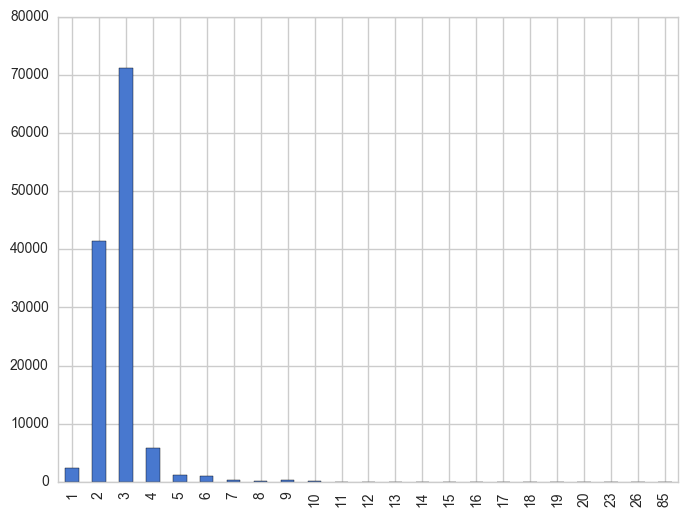

In [5]:
def tokens(x):
    return len(x.split(' '))
d.loc[:, 'daddr_num_words'] = d.display_address.map(lambda x: tokens(x))
d.daddr_num_words.value_counts().sort_index().plot(kind='bar')

In [6]:
int(False)

0

In [7]:
def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def has_number(x):
    return int(any([represents_int(w.strip()) for w in x.split(' ')]))
    
d.loc[:, 'daddr_has_number'] = d.display_address.map(lambda x: has_number(x))
d.head()

,display_address,daddr_num_words,daddr_has_number
id,,,
0,Suffolk Street,2,0
1,Thompson Street,2,0
10,Metropolitan Avenue,2,0
100,101 East 10th Street,4,1
1000,South Third Street\r,4,0


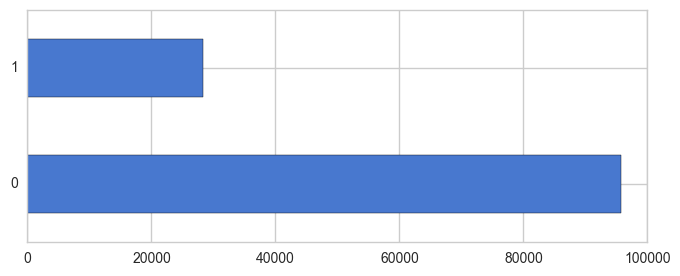

In [8]:
d.daddr_has_number.value_counts().plot(kind='barh', figsize=(8,3))

## Does the address contain any ordinal numbers?


In [9]:
import re
p = re.compile('[0-9]+[a-z]+')

def is_ordinal(w):    
    return p.match(w) != None

def has_ordinal_number(x):
    return int(any([is_ordinal(w.strip().lower()) for w in x.split(' ')]))
    
d.loc[:, 'daddr_has_ordinal'] = d.display_address.map(lambda x: has_ordinal_number(x))
d.head()

,display_address,daddr_num_words,daddr_has_number,daddr_has_ordinal
id,,,,
0,Suffolk Street,2,0,0
1,Thompson Street,2,0,0
10,Metropolitan Avenue,2,0,0
100,101 East 10th Street,4,1,1
1000,South Third Street\r,4,0,0


## Number of uppercase words

Note that there are a lot of addresses that contain a single-letter "word" which is uppercase, usually referring to East, West, etc
For example: E 78th St., W 68 Street.
I've excluded these single letter words because I think it's ok to treat them as normal.

In [10]:
import re
uppercase_pattern = re.compile('^[A-Z]+$')


def is_uppercase(w):    
    return uppercase_pattern.match(w) != None

def uppercase_word_count(x):
    return len([w for w in x.split(' ') if is_uppercase(w.strip()) and len(w) > 1])
    
d.loc[:, 'daddr_num_upper_words'] = d.display_address.map(lambda x: uppercase_word_count(x))
d.head()

,display_address,daddr_num_words,daddr_has_number,daddr_has_ordinal,daddr_num_upper_words
id,,,,,
0,Suffolk Street,2,0,0,0
1,Thompson Street,2,0,0,0
10,Metropolitan Avenue,2,0,0,0
100,101 East 10th Street,4,1,1,0
1000,South Third Street\r,4,0,0,0


In [11]:
d[d.daddr_num_upper_words >2].head()

,display_address,daddr_num_words,daddr_has_number,daddr_has_ordinal,daddr_num_upper_words
id,,,,,
100600,UWS! NO FEE NO FEE****as,6,0,0,3
100680,GRAMERCY______BRAND NEW RENOVATED TRUE 3 BEDROOM 2 BATH IN THE HEART OF GRAMERCY_____CALL TODAY WILL NOT LAST!!!!,18,1,0,12
100777,NO MISTAKES HERE -> Chelsea<-,5,0,0,3
10082,MASSIVE 5BED/3BATH* PANORAMIC BK VIEWS* 2000SQFT,6,0,1,3
101617,WILL NOT LAST LONG!,5,0,0,3


In [12]:
d.daddr_num_upper_words.value_counts()

0     122748
1        438
2        430
3        174
4         87
5         53
6         23
7         18
8         10
9          9
10         7
12         3
13         3
15         3
11         2
18         1
14         1
24         1
Name: daddr_num_upper_words, dtype: int64

# Save the Data

In [13]:
del d['display_address']

In [14]:
d.to_csv('tmp/features_display_address.csv', encoding='utf-8’')